In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [28]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','0_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

180000 rows
360000 rows
540000 rows


In [29]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [30]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [36]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
#         data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 50000;", conn_r)
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 50000;", conn_r)
#         print(data)
        conn_r.commit()
        conn_r.close()

In [37]:
data.shape

(50000, 32)

In [38]:
# data['374_y']

In [39]:
type(data)

pandas.core.frame.DataFrame

In [40]:
# data.astype(float)

In [41]:
# data[(data != 0).all(1)]

In [42]:
# data.shape

In [43]:
# data

In [44]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [45]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,0_y
1,0.799984000319994,0.799984000319994,0.749981250468738,0.499991666805553,0.77776913589849,0.636357851292261,1.0,1.0,2.0,10.0,...,51,9,11,7.0,20.0,0.35,2,0,1.17733214741262,1.46119048382388
2,0.333327777870369,0.19999800002,0.249996875039062,0.181816528940646,0.249998437509766,0.173912287337881,0.0,0.0,7.0,19.5,...,137,16,23,4.0,35.0,0.114285714285714,10,8,2.43751967642489,3.76077113106294
3,0.33332222259258,0.33332222259258,0.749981250468738,0.749981250468738,0.571420408279882,0.571420408279882,1.0,1.0,0.0,7.0,...,31,7,7,4.0,14.0,0.285714285714286,3,1,0.732249386965123,1.038626804521
4,0.374995312558593,0.374995312558593,0.249993750156246,0.199996000079998,0.307689940846609,0.285712244912536,0.0,0.0,1.0,13.5,...,75,13,14,3.0,25.0,0.12,2,0,1.66568638817019,2.3179113910713
5,0.799984000319994,0.666655555740738,0.66664444518516,0.399992000159997,0.666659259341563,0.599994000059999,0.0,0.0,1.0,9.5,...,59,9,10,4.0,19.0,0.210526315789474,2,0,1.46228249394335,1.27306798092953


In [46]:
type(data)

pandas.core.frame.DataFrame

<h2> 4.2 Converting strings to numerics </h2>

In [47]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
# print(cols)
print(type(data.cwc_min[1]))  # Checking type of columns
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)
# for i in cols:
#     data.i = data.i.astype(int)
#     print(i)


# data = data.astype(int)

<class 'str'>
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
0_y


In [48]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))
# for i in y_true:
#     print(i)
# results = [int(i) for i in y_true.values]
# y_true = y_true.astype(int)
# y_true = y_true.values
# results

In [49]:
# y_true.shape

<h2> 4.3 Random train test split( 70:30) </h2>

In [50]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [51]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (34999, 28)
Number of data points in test data : (15000, 28)


In [52]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6295894168404812 Class 1:  0.37041058315951886
---------- Distribution of output variable in train data ----------
Class 0:  0.3704 Class 1:  0.3704


In [53]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.887388956362789


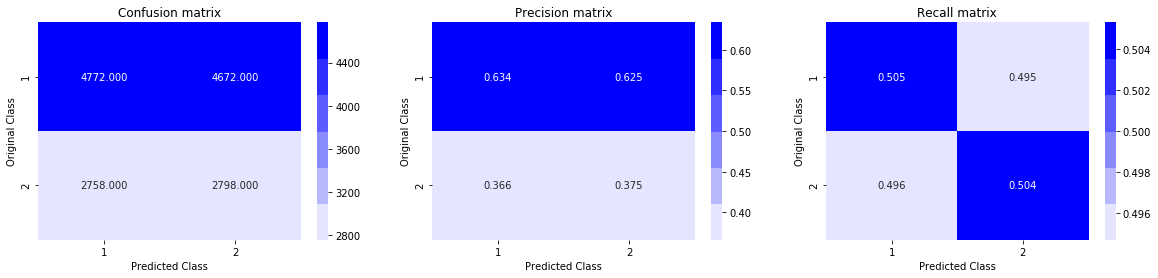

In [54]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.505177212162014
For values of alpha =  0.0001 The log loss is: 0.49106900986742985
For values of alpha =  0.001 The log loss is: 0.5027721820871036
For values of alpha =  0.01 The log loss is: 0.49106451252788025
For values of alpha =  0.1 The log loss is: 0.4677549657548766
For values of alpha =  1 The log loss is: 0.49127046936598073
For values of alpha =  10 The log loss is: 0.5457561982901757


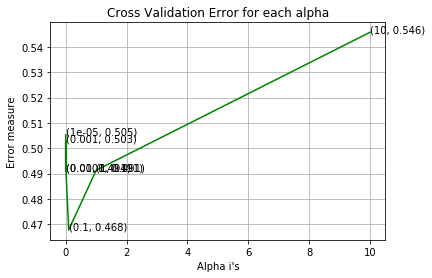

For values of best alpha =  0.1 The train log loss is: 0.4691220756851126
For values of best alpha =  0.1 The test log loss is: 0.4677549657548766
Total number of data points : 15000


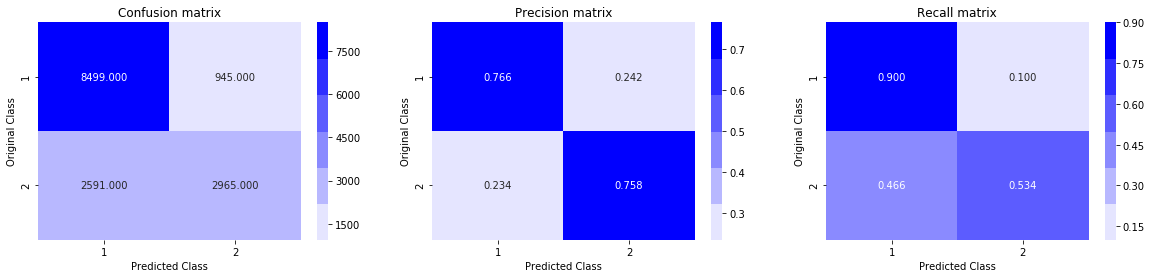

In [55]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4930447479322765
For values of alpha =  0.0001 The log loss is: 0.5039040956002447
For values of alpha =  0.001 The log loss is: 0.5105834168552579
For values of alpha =  0.01 The log loss is: 0.5030541485020249
For values of alpha =  0.1 The log loss is: 0.49959109647437194
For values of alpha =  1 The log loss is: 0.5690157128121357
For values of alpha =  10 The log loss is: 0.6335160663821808


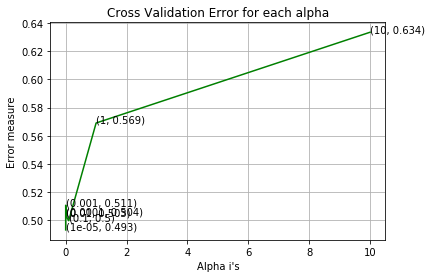

For values of best alpha =  1e-05 The train log loss is: 0.4907209380935635
For values of best alpha =  1e-05 The test log loss is: 0.4930447479322765
Total number of data points : 15000


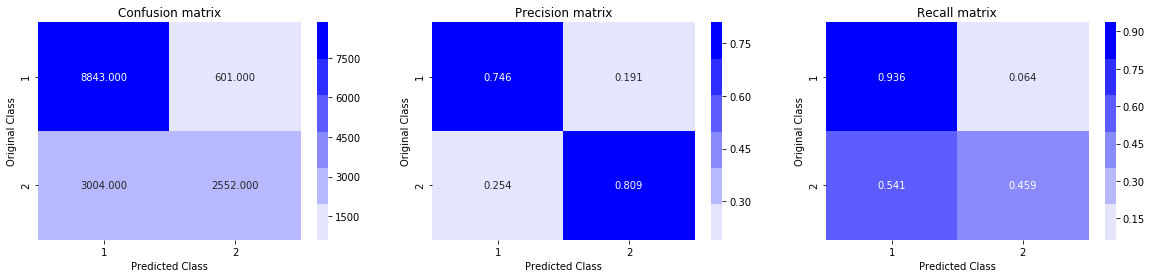

In [56]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [57]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684614	valid-logloss:0.684653
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.614341	valid-logloss:0.6145
[20]	train-logloss:0.563032	valid-logloss:0.563259
[30]	train-logloss:0.524489	valid-logloss:0.524852
[40]	train-logloss:0.494753	valid-logloss:0.495211
[50]	train-logloss:0.471681	valid-logloss:0.472374
[60]	train-logloss:0.453339	valid-logloss:0.454264
[70]	train-logloss:0.438597	valid-logloss:0.439788
[80]	train-logloss:0.426815	valid-logloss:0.42823
[90]	train-logloss:0.417122	valid-logloss:0.418751
[100]	train-logloss:0.409161	valid-logloss:0.411012
[110]	train-logloss:0.402624	valid-logloss:0.404687
[120]	train-logloss:0.3968	valid-logloss:0.399073
[130]	train-logloss:0.391817	valid-logloss:0.394265
[140]	train-logloss:0.387615	valid-logloss:0.390259
[150]	train-logloss:0.384226	valid-logloss:0.387077
[160]	train-logloss:0.381054	vali

Total number of data points : 15000


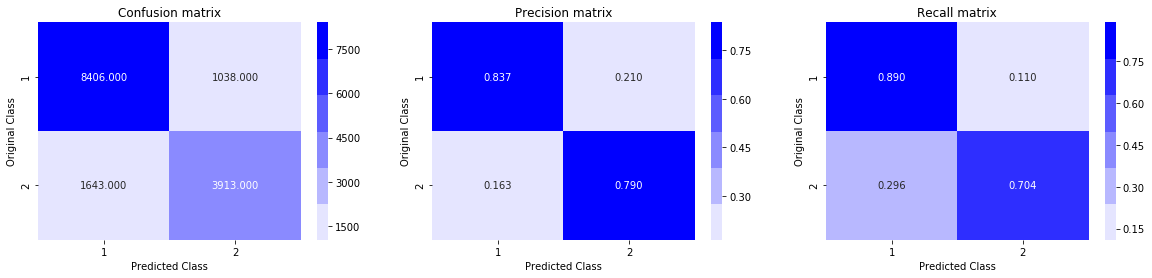

In [58]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


# 5.1 Converting data to tfidf values.

In [59]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [60]:
dfnlp = dfnlp[0:100001]
dfppro = dfppro[0:100001]
df1 = pd.DataFrame(dfnlp['question1'].apply(lambda x: str(x)), columns = ['question1'])
df1['question2'] = dfnlp['question2'].apply(lambda x: str(x))
# df1['question1'] = dfnlp['question1'].apply(lambda x: str(x))
# df1['question2'] = dfnlp['question2'].apply(lambda x: str(x))

In [61]:
# df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [62]:
df1  = dfnlp.merge(df2, on='id',how='left')

In [63]:
df1 = df1[0:100001]

In [64]:
# print(type(dfnlp))

In [65]:
Y = dfppro[0:100001]['is_duplicate']

In [66]:
df1.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [77]:
print(df1.shape)

(100001, 32)


In [68]:
X_train,X_test, y_train, y_test = train_test_split(df1, Y, stratify=Y, test_size=0.3)

In [69]:
# X_train

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
# questions = list(df['question1']) + list(df['question2'])

tfidf_question1 = TfidfVectorizer(lowercase=False, )
tfidf_question1.fit(X_train['question1'].apply(lambda x: str(x)))
tfidf_question1_train = tfidf_question1.transform(X_train['question1'].apply(lambda x: str(x)))
tfidf_question1_test = tfidf_question1.transform(X_test['question1'].apply(lambda x: str(x)))

tfidf_question2 = TfidfVectorizer(lowercase=False, )
tfidf_question2.fit(X_train['question2'].apply(lambda x: str(x)))
tfidf_question2_train = tfidf_question2.transform(X_train['question2'].apply(lambda x: str(x)))
tfidf_question2_test = tfidf_question2.transform(X_test['question2'].apply(lambda x: str(x)))

print("the shape of out text TFIDF vectorizer ",tfidf_question1_train.get_shape())
print("the shape of out text TFIDF vectorizer ",tfidf_question1_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_question2_train.get_shape())
print("the shape of out text TFIDF vectorizer ",tfidf_question2_test.get_shape())
# dict key:word and value:tf-idf score
# word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

the shape of out text TFIDF vectorizer  (70000, 31209)
the shape of out text TFIDF vectorizer  (30001, 31209)
the number of unique words including both unigrams and bigrams  (70000, 29159)
the shape of out text TFIDF vectorizer  (30001, 29159)


In [71]:
from scipy import sparse

#Save
sparse.save_npz('tfidf_question1_train.npz', tfidf_question1_train)
sparse.save_npz('tfidf_question2_train.npz', tfidf_question2_train)
sparse.save_npz('tfidf_question1_test.npz', tfidf_question1_test)
sparse.save_npz('tfidf_question2_test.npz', tfidf_question2_test)

#Load
# data = sparse.load_npz("data_sparse.npz")

In [72]:
# removing the 'qid1','qid2','question1','question2','is_duplicate' columns from train and test data.
X_train = X_train.drop([ 'qid1','qid2','question1','question2','is_duplicate'],axis=1)
X_test = X_test.drop([ 'qid1','qid2','question1','question2','is_duplicate'],axis=1)

# merging train and test data to tfidf vecter of train and test data

In [73]:
mat_train = sparse.hstack((X_train,tfidf_question1_train))
mat_test = sparse.hstack((X_test,tfidf_question1_test))

In [74]:
mat_train = sparse.hstack((mat_train,tfidf_question2_train))
mat_test = sparse.hstack((mat_test,tfidf_question2_test))

In [75]:
mat_test

<30001x60395 sparse matrix of type '<class 'numpy.float64'>'
	with 1328560 stored elements in COOrdinate format>

# 5.2 Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.6602837380294572
For values of alpha =  0.0001 The log loss is: 0.6602837380294572
For values of alpha =  0.001 The log loss is: 0.6602837380294572
For values of alpha =  0.01 The log loss is: 0.6602837380294572
For values of alpha =  0.1 The log loss is: 0.6602837380294572
For values of alpha =  1 The log loss is: 0.6602837380294572
For values of alpha =  10 The log loss is: 0.6602837380294572


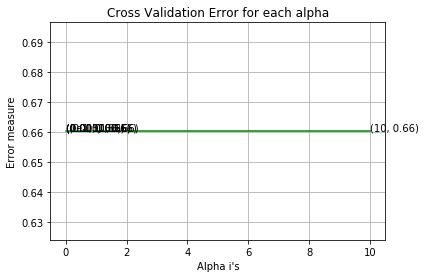

For values of best alpha =  1e-05 The train log loss is: 0.6602951754487361
For values of best alpha =  1e-05 The test log loss is: 0.6602837380294572
Total number of data points : 30001


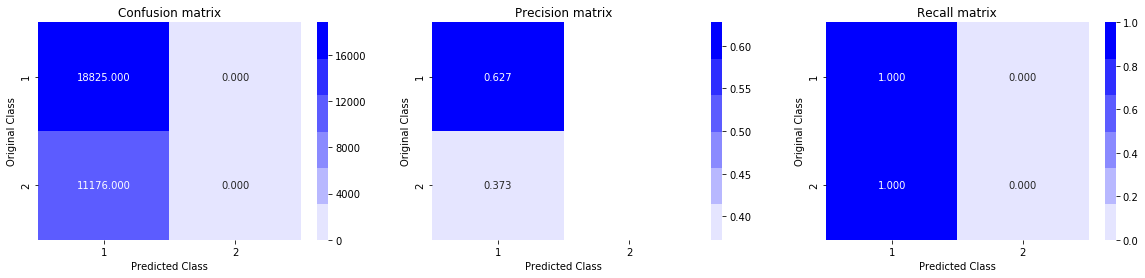

In [76]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(mat_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(mat_train, y_train)
    predict_y = sig_clf.predict_proba(mat_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(mat_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(mat_train, y_train)

predict_y = sig_clf.predict_proba(mat_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(mat_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

for alpha = 10 loss is minimum, we are getting 62.7% precision and 100% recall for the questions that are not similar and 0% precision 0% recall for the questions that are similar.

# <h2> 5.3 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6602837380294572
For values of alpha =  0.0001 The log loss is: 0.6602837380294572
For values of alpha =  0.001 The log loss is: 0.6602837380294572
For values of alpha =  0.01 The log loss is: 0.6602837380294572
For values of alpha =  0.1 The log loss is: 0.6363809956504088
For values of alpha =  1 The log loss is: 0.6133124735195263
For values of alpha =  10 The log loss is: 0.6559659202502899


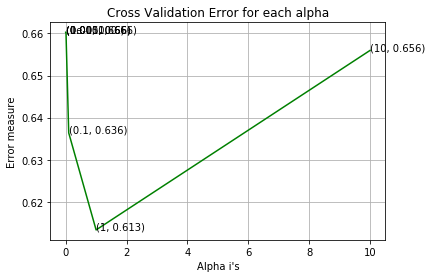

For values of best alpha =  1 The train log loss is: 0.6129915033470172
For values of best alpha =  1 The test log loss is: 0.6133124735195263
Total number of data points : 30001


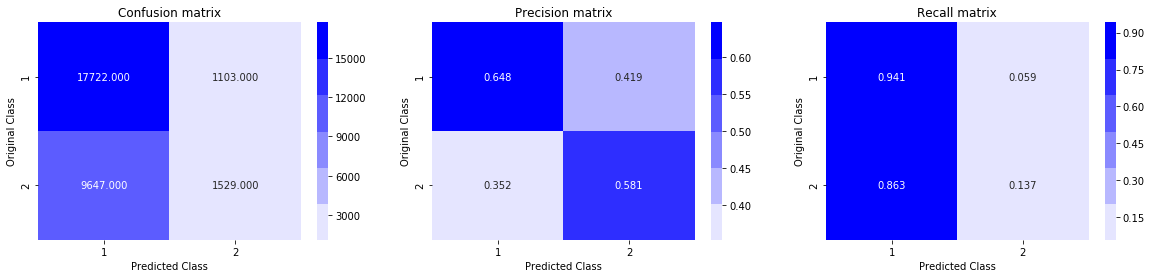

In [78]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(mat_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(mat_train, y_train)
    predict_y = sig_clf.predict_proba(mat_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(mat_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(mat_train, y_train)

predict_y = sig_clf.predict_proba(mat_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(mat_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

for alpha = 1 loss is minimum, we are getting 64.2% precision and 94.1% recall for the questions that are not similar and 58.1% precision 13.7% recall for the questions that are similar.

# 5.4 XGBoost Approch

In [79]:
import xgboost as xgb

depth = [2 ** x for x in range(2, 5)]
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02

for values in depth:
    params['max_depth'] = values
    print("XGBoost for the depth of ",params['max_depth'])
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(d_train, 'train'), (d_test, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

    xgdmat = xgb.DMatrix(X_train,y_train)
    predict_y = bst.predict(d_test)
    print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

XGBoost for the depth of  4
[0]	train-logloss:0.684881	valid-logloss:0.684887
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.616211	valid-logloss:0.616721
[20]	train-logloss:0.5655	valid-logloss:0.566324
[30]	train-logloss:0.527334	valid-logloss:0.528541
[40]	train-logloss:0.497837	valid-logloss:0.499237
[50]	train-logloss:0.474863	valid-logloss:0.476451
[60]	train-logloss:0.456681	valid-logloss:0.458359
[70]	train-logloss:0.442033	valid-logloss:0.443809
[80]	train-logloss:0.430242	valid-logloss:0.432075
[90]	train-logloss:0.420744	valid-logloss:0.422544
[100]	train-logloss:0.412526	valid-logloss:0.414388
[110]	train-logloss:0.40587	valid-logloss:0.407764
[120]	train-logloss:0.400213	valid-logloss:0.40216
[130]	train-logloss:0.39541	valid-logloss:0.397401
[140]	train-logloss:0.391108	valid-logloss:0.393322
[150]	train-logloss:0.387331	valid-logloss:0.389668
[160]

In all the values of depth [4,8,16], our train and test log loss is approximatly same, and for depth= 8 our model give less log loss value as compare to log loss that we getting in depth 4,16. So i am considering 8 as a appropriate depth.   

### Building model on depth = 8

In [80]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 8
print("XGBoost for the depth of ",params['max_depth'])
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

XGBoost for the depth of  8
[0]	train-logloss:0.683086	valid-logloss:0.683317
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.600704	valid-logloss:0.603177
[20]	train-logloss:0.54182	valid-logloss:0.546321
[30]	train-logloss:0.497628	valid-logloss:0.504262
[40]	train-logloss:0.463688	valid-logloss:0.47228
[50]	train-logloss:0.437204	valid-logloss:0.447517
[60]	train-logloss:0.41611	valid-logloss:0.428177
[70]	train-logloss:0.399239	valid-logloss:0.412773
[80]	train-logloss:0.385571	valid-logloss:0.400539
[90]	train-logloss:0.37451	valid-logloss:0.39061
[100]	train-logloss:0.365426	valid-logloss:0.382651
[110]	train-logloss:0.358053	valid-logloss:0.376295
[120]	train-logloss:0.351426	valid-logloss:0.370954
[130]	train-logloss:0.345925	valid-logloss:0.366589
[140]	train-logloss:0.341467	valid-logloss:0.362985
[150]	train-logloss:0.337714	valid-logloss:0.360097
[160]

Total number of data points : 30001


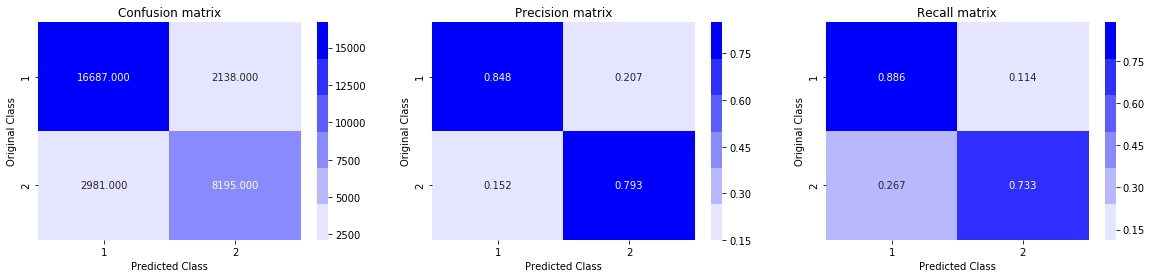

In [81]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

for depth = 8, we are getting 84.8% precision and 88.6% recall for the questions that are not similar and 79.3% precision 73.3% recall for the questions that are similar.

# 5.5 Conclusion -:

### Logistic Regression -:
we are getting 62.7% precision and 100% recall for the questions that are not similar and 0% precision 0% recall for the questions that are similar.

### Linear SVM -:
we are getting 64.2% precision and 94.1% recall for the questions that are not similar and 58.1% precision 13.7% recall for the questions that are similar.

### XGBoost -:
 we are getting 84.8% precision and 88.6% recall for the questions that are not similar and 79.3% precision 73.3% recall for the questions that are similar.

## From the detail of precision and recall it is clear that XGBoost perform well on data. Because We are getting High precision and recall values for both (Similar Question or non Similar Questions).